In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import matplotlib.transforms as tran
import sys
import collections
from decimal import Decimal
import pandas as pd
from astropy.io import fits
from astropy.io import ascii as astro_write
from astropy.table import Table, Column
plt.rcParams['figure.figsize'] = [10, 5]

`FullDataset` is used for storing the model spectra data for all abundances and microturbulence values in a grid for a given T_eff and log G. `get_micro_abund_storage` returns a spectra for a given mt vel/abund from the full dataset.

In [2]:
class FullDataset:
    def __init__(self, filename, eff_temp=-1.0, log_g=-1.0):
                self.eff_temp = eff_temp
                self.log_g = log_g
                self.storage, self.error_storage = self.read_data(filename)
    def read_data(self, filename):#stored in dict, first num indicates the micro/abund combo, second indicates ionization stage, third is the line location
        f = open(filename, "r")
        f_lines = f.readlines()
        f.close()
        storage = dict()
        error_storage=dict()
        for i in range(27):
                storage[i]=dict()
                error_storage[i]=dict()
        # 12-Line location, 4-EW, 13-Transition 
        read_cols = [13, 12, 4]
        start_ind=0
        start_str=f_lines[0]
        while start_str[0:11] !="!       XST":
            start_ind+=1  
            start_str=f_lines[start_ind]
        print(start_ind)
        count=0
        for l in f_lines[start_ind+1:]:
            line = l.split()
            # if labeled species
            if len(line) > 13 and '(' in line[13]:
                    k = line[13][:line[13].index('(')]
                    if not k in storage[count%27]:
                            storage[count%27][k] = dict()
                            error_storage[count%27][k] = dict()
                    storage[count%27][k][float(line[12])]=float(line[4])
                    error_storage[count%27][k][float(line[12])]=float(line[5])
            count+=1
        return storage, error_storage
    def get_micro_abund_storage(self, micro, abund):#returns sub-dict of micro/abund combo
        abund=str(abund)
        abund_convert={"":0,"C/2":1,"C*2":2,"N/2":3,"N*2":4,"O/2":5,"O*2":6,"SI/2":7,"SI*2":8}
        if micro == 1:
            if abund.isdigit():
                return self.storage[0+int(abund)]
            else:
                return self.storage[0+abund_convert[abund]]
        elif micro == 3:
            if abund.isdigit():
                return self.storage[9+int(abund)]
            else:
                return self.storage[9+abund_convert[abund]]
        elif micro == 5:
            if abund.isdigit():
                return self.storage[18+int(abund)]
            else:
                return self.storage[18+abund_convert[abund]]
        else:
                print("Error: incorrect microturbulence value entered")
                sys.exit(0)
    def get_micro_abund_error_storage(self, micro, abund):#returns sub-dict of micro/abund combo
        abund=str(abund)
        abund_convert={"":0,"C/2":1,"C*2":2,"N/2":3,"N*2":4,"O/2":5,"O*2":6,"SI/2":7,"SI*2":8}
        if micro == 1:
            if abund.isdigit():
                return self.error_storage[0+int(abund)]
            else:
                return self.error_storage[0+abund_convert[abund]]
        elif micro == 3:
            if abund.isdigit():
                return self.error_storage[9+int(abund)]
            else:
                return self.error_storage[9+abund_convert[abund]]
        elif micro == 5:
            if abund.isdigit():
                return self.error_storage[18+int(abund)]
            else:
                return self.error_storage[18+abund_convert[abund]]
        else:
                print("Error: incorrect microturbulence value entered")
                sys.exit(0)


`ObsDataset` is also a storage class for the observed data, with one variable storing ew values and one storing error values.

In [3]:
class ObsDataset:
    def __init__(self, filename):
            self.storage, self.error_storage = self.read_data(filename)
    def read_data(self, filename):
            f = open(filename, "r")
            f_lines = f.readlines()
            f.close()
            storage = dict()
            error_storage = dict()
            # 12-Line location, 4-EW, 13-Transition
            read_cols = [13, 12, 4]
            for l in f_lines[4:]:
                    line = l.split()
                    # if labeled species
                    if len(line) > 13 and '(' in line[13]:
                            k = line[13][:line[13].index('(')]
                            if not k in storage:
                                    storage[k] = dict()
                                    error_storage[k]=dict()
                            storage[k][float(line[12])]=float(line[4])
                            error_storage[k][float(line[12])]=float(line[5])
            return storage, error_storage


`get_ionization_counts` counts the number of lines for each ionization species present and shared by both an observed dataset and a model dataset.

In [4]:
def get_ionization_counts(obs_dataset, other_dataset):
    count_dict={}    
    for species in obs_dataset:
            if species in other_dataset:
                if species not in count_dict:
                    count_dict[species]=0
                for line in obs_dataset[species]:
                    if line in other_dataset[species]:
                        count_dict[species]=count_dict[species]+1
    return count_dict

`chi_component` runs a single squared error calculation which can be summed to get a full $\chi^2$ value.

In [5]:
def chi_component(obs_val, mod_val, error):
    return ((obs_val-mod_val)/(error*obs_val))**2

`get_chi_val` and `get_chi_val_interp` both calculate the chi-value sums for both interpolated and non-interpolated EW values.

In [6]:
def get_chi_val(obs_dataset, other_dataset):
    sum = 0.0
    #count_dict = get_ionization_counts(obs_dataset,other_dataset)
    for species in obs_dataset.storage:
            if species in other_dataset and species != "Ca2":#ignore telluric calcium line
                for line in obs_dataset.storage[species]:
                    if line in other_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset[species][line]
                        sum += chi_component(ew1,ew2,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans
def get_chi_val_interp(obs_dataset, other_dataset1, other_dataset2):
    sum = 0.0
    #count_dict = get_ionization_counts(obs_dataset,other_dataset1)
    for species in obs_dataset.storage:
        if species in other_dataset1 and species in other_dataset2 and species != "Ca2":
            for line in obs_dataset.storage[species]:
                if line in other_dataset1[species] and line in other_dataset2[species]:
                    ew1 = obs_dataset.storage[species][line]
                    ew2 = other_dataset1[species][line]
                    ew3 = other_dataset2[species][line]
                    ex = float((ew2+ew3)/2)
                    sum += chi_component(ew1,ex,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans

In [7]:
def get_chi_val_filter(obs_dataset, other_dataset, species_list):
    sum = 0.0
    #count_dict = get_ionization_counts(obs_dataset,other_dataset)
    for species in obs_dataset.storage:
            if species in other_dataset and species in species_list:
                for line in obs_dataset.storage[species]:
                    if line in other_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset[species][line]
                        sum += chi_component(ew1,ew2,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans
def get_chi_val_interp_filter(obs_dataset, other_dataset1, other_dataset2, species_list):
    sum = 0.0
    #count_dict = get_ionization_counts(obs_dataset,other_dataset1)
    for species in obs_dataset.storage:
        if species in other_dataset1 and species in other_dataset2 and species in species_list:
            for line in obs_dataset.storage[species]:
                if line in other_dataset1[species] and line in other_dataset2[species]:
                    ew1 = obs_dataset.storage[species][line]
                    ew2 = other_dataset1[species][line]
                    ew3 = other_dataset2[species][line]
                    ex = float((ew2+ew3)/2)
                    sum += chi_component(ew1,ex,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans

`plot_chi_wavelength` plots the chi-square value for each line over the full wavelength with blue points indicating model values greater than observed, and red points indicating the opposite.

In [8]:
def plot_chi_wavelength(obs_dataset, other_dataset,filter_list=None):#obs_storage, other_dataset.storage list
        pos_x_vals = []
        pos_y_vals = []
        pos_species_line = []
        neg_x_vals = []
        neg_y_vals = []
        neg_species_line = []

        #count_dict = get_ionization_counts(obs_dataset,other_dataset)
        #print(count_dict)
        for species in obs_dataset.storage:
            if filter_list == None and species in other_dataset:
                for line in obs_dataset.storage[species]:
                    if line in other_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset[species][line]
                        if (ew1-ew2)>=0.0:
                            neg_x_vals.append(line)
                            neg_y_vals.append(chi_component(ew1,ew2,obs_dataset.error_storage[species][line]))
                            neg_species_line.append(species+" "+str(line))
                        else:
                            pos_x_vals.append(line)
                            pos_y_vals.append(chi_component(ew1,ew2,obs_dataset.error_storage[species][line]))
                            pos_species_line.append(species+" "+str(line))
            elif species in filter_list and species in other_dataset:
                for line in obs_dataset.storage[species]:
                    if line in other_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset[species][line]
                        if (ew1-ew2)>=0.0:
                            neg_x_vals.append(line)
                            neg_y_vals.append(chi_component(ew1,ew2,obs_dataset.error_storage[species][line]))
                            neg_species_line.append(species+" "+str(line))
                        else:
                            pos_x_vals.append(line)
                            pos_y_vals.append(chi_component(ew1,ew2,obs_dataset.error_storage[species][line]))
                            pos_species_line.append(species+" "+str(line))
            else:
                continue
        plt.figure(figsize=(12,6))
        plt.scatter(pos_x_vals,pos_y_vals,c='blue',label="Overestimate")
        for i, txt in enumerate(pos_species_line):
            plt.annotate(txt,(pos_x_vals[i],pos_y_vals[i]),xytext=(0.0,65.0),textcoords='offset points',rotation=90)
        plt.scatter(neg_x_vals,neg_y_vals,c='red',label="Underestimate")
        for i, txt in enumerate(neg_species_line):
            plt.annotate(txt,(neg_x_vals[i],neg_y_vals[i]),xytext=(0.0,65.0),textcoords='offset points',rotation=90)
        plt.axhline(y = 0.0, color = 'black', linestyle = 'dashed')
        #plt.xlim([4200,4400])
        #plt.ylim([-1,20])
        plt.xlabel("Wavelength (Angstroms)")
        plt.ylabel("Chi-square contribution")
        plt.legend(loc ="upper right")
        
        plt.show()

`plot_error_ew` plots the observed error values as a function of EW values on a logarithmic scale.

In [9]:
def plot_error_ew(obs_dataset):#obs_storage, other_dataset.storage list 
        x_vals = []
        y_vals = []

        #print(count_dict)
        ews = obs_dataset.storage
        errors = obs_dataset.error_storage
        for species in ews:
                for line in ews[species]:
                        x_vals.append(ews[species][line])
                        y_vals.append(errors[species][line])
        plt.scatter(x_vals,y_vals,c='blue')
        plt.xlabel("EW (mA)")
        plt.ylabel("Error (%)")
        plt.xscale("log")
        plt.show()

`get_chi_val_abund` and `get_chi_val_abund_interp` run the chi-square calculations for the abundance replacement chi-square calculations.

In [10]:
def get_chi_val_abund(obs_dataset, mod_dataset, mt, abund):
    sum = 0.0
    other_dataset = mod_dataset.get_micro_abund_storage(mt,abund)
    #count_dict = get_ionization_counts(obs_dataset,other_dataset)
    for species in obs_dataset.storage:
            if species in other_dataset and (species == "C2" or species == "CIII" or species == "CIV"):
                carbon_dataset = mod_dataset.get_micro_abund_storage(mt,"C*2")
                for line in obs_dataset.storage[species]:
                    if line in carbon_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = carbon_dataset[species][line]
                        sum += chi_component(ew1,ew2,obs_dataset.error_storage[species][line])
            elif species in other_dataset and species != "Ca2":
                for line in obs_dataset.storage[species]:
                    if line in other_dataset[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset[species][line]
                        sum += chi_component(ew1,ew2,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans
def get_chi_val_abund_interp(obs_dataset, mod_dataset, mt, abund):
    sum = 0.0
    other_dataset_1 = mod_dataset.get_micro_abund_storage(mt-1,abund)
    other_dataset_2 = mod_dataset.get_micro_abund_storage(mt+1,abund)
    #count_dict = get_ionization_counts(obs_dataset,other_dataset_1)
    for species in obs_dataset.storage:
           if species in other_dataset_1 and species in other_dataset_2 and (species == "C2" or species == "CIII" or species == "CIV"):
                carbon_dataset_1 = mod_dataset.get_micro_abund_storage(mt-1,"C*2")
                carbon_dataset_2 = mod_dataset.get_micro_abund_storage(mt+1,"C*2")
                for line in obs_dataset.storage[species]:
                    if line in carbon_dataset_1[species] and line in carbon_dataset_2[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = carbon_dataset_1[species][line]
                        ew3 = carbon_dataset_2[species][line]
                        ex = float((ew2+ew3)/2)
                        sum += chi_component(ew1,ex,obs_dataset.error_storage[species][line])
           elif species in other_dataset_1 and species in other_dataset_2 and species != "Ca2":
                for line in obs_dataset.storage[species]:
                    if line in other_dataset_1[species] and line in other_dataset_2[species]:
                        ew1 = obs_dataset.storage[species][line]
                        ew2 = other_dataset_1[species][line]
                        ew3 = other_dataset_2[species][line]
                        ex = float((ew2+ew3)/2)
                        sum += chi_component(ew1,ex,obs_dataset.error_storage[species][line])
    ans = round(sum,2)
    return ans

`plot_best_fit_abund_chi_value` returns a table with the best mt/abundance combo marked in green based on the chi-square value with a given abundance replacement.

In [11]:
def plot_abund_chi_square(obs_dataset, mod_dataset):
    txt_table=[[],[],[],[],[]]#5 mt rows, 9 abund cols
    for i in range(1,6):
        if i in [1,3,5]:
            for j in range(9):
                txt_table[i-1].append(get_chi_val_abund(obs_dataset,mod_dataset,i,j))
        else:
            for j in range(9):
                txt_table[i-1].append(get_chi_val_abund_interp(obs_dataset,mod_dataset,i,j))

    colors=[[],[],[],[],[]]
    lowest_val = 10000000000000
    lowest_indexes = (0,0)
    for mt in range(5):
        for abund in range(9):
            if(txt_table[mt][abund]<lowest_val):
                lowest_val=txt_table[mt][abund]
                lowest_indexes=(mt,abund)
            colors[mt].append("white")
    colors[lowest_indexes[0]][lowest_indexes[1]]='green'
    return (txt_table, colors)

`plot_chi_square` returns a table with the best mt/abundance combo marked in green based on the chi-square value.

In [12]:
def plot_chi_square(obs_dataset,mod_dataset):
    txt_table=[[],[],[],[],[]]#5 mt rows, 9 abund cols
    for i in range(1,6):
        if i in [1,3,5]:
            for j in range(9):
                txt_table[i-1].append(get_chi_val(obs_dataset,mod_dataset.get_micro_abund_storage(i,j)))
        else:
            for j in range(9):
                txt_table[i-1].append(get_chi_val_interp(obs_dataset,mod_dataset.get_micro_abund_storage(i-1,j),mod_dataset.get_micro_abund_storage(i+1,j)))

    colors=[[],[],[],[],[]]
    lowest_val = 10000000000000
    lowest_indexes = (0,0)
    for mt in range(5):
        for abund in range(9):
            if(txt_table[mt][abund]<lowest_val):
                lowest_val=txt_table[mt][abund]
                lowest_indexes=(mt,abund)
            colors[mt].append("white")
    colors[lowest_indexes[0]][lowest_indexes[1]]='green'
    #for row_ind, row in enumerate(txt_table):
    #    for col_ind, i in enumerate(row):
    #        txt_table[row_ind][col_ind]='%.2E' % Decimal(i)
    return (txt_table, colors)

In [13]:
def plot_chi_square_filter(obs_dataset,mod_dataset):
    txt_table=[[],[],[],[],[]]#5 mt rows, 9 abund cols
    #helper_dict = ["C2","CIII","CIV"],["OIII","O2","OIV"],["SkIII","SkIV"],["HeI"],["HI"]
    filter_list = ["SkIII","SkIV"]
    for i in range(1,6):
        if i in [1,3,5]:
            for j in range(9):
                txt_table[i-1].append(get_chi_val_filter(obs_dataset,mod_dataset.get_micro_abund_storage(i,j),filter_list))
        else:
            for j in range(9):
                txt_table[i-1].append(get_chi_val_interp_filter(obs_dataset,mod_dataset.get_micro_abund_storage(i-1,j),mod_dataset.get_micro_abund_storage(i+1,j),filter_list))

    colors=[[],[],[],[],[]]
    lowest_val = 10000000000000
    lowest_indexes = (0,0)
    for mt in range(5):
        for abund in range(9):
            if(txt_table[mt][abund]<lowest_val):
                lowest_val=txt_table[mt][abund]
                lowest_indexes=(mt,abund)
            colors[mt].append("white")
    colors[lowest_indexes[0]][lowest_indexes[1]]='green'
    #for row_ind, row in enumerate(txt_table):
    #    for col_ind, i in enumerate(row):
    #        txt_table[row_ind][col_ind]='%.2E' % Decimal(i)
    return (txt_table, colors)

`plot_chi_table` takes the output from the previous two functions and plots the tables on screen.

In [14]:
def plot_chi_table(obs_dataset, table_func, mod_dataset_list):
        fig = plt.figure(1,figsize=(11,7))
        ax_main = fig.add_subplot(111) 
        count=1
        min_val, max_val = 100000000000000.0,0.0
        for mod_dataset in mod_dataset_list:
            ax_data = table_func(obs_dataset, mod_dataset)
            df=pd.DataFrame(ax_data[0])
            if min_val>df.values.min():
                min_val=df.values.min()
            if max_val<df.values.max():
                max_val=df.values.max()
        for mod_dataset in mod_dataset_list:
            if count==3:
                count=4
            ax = fig.add_subplot(3,3,count)
            ax.axis("off")
            ax.axis("tight")
            ax_data = table_func(obs_dataset, mod_dataset)
            df = pd.DataFrame(ax_data[0],index=["MT1", "MT2", "MT3", "MT4", "MT5"],columns=["---","C/2","C*2","N/2","N*2","O/2","O*2","SI/2","SI*2"]) 
            norm = plt.Normalize(min_val, max_val)
            colors = plt.cm.summer_r(norm(df.values))
            tbl = ax.table(cellText=df.values,cellColours=colors,rowLabels=df.index, colLabels=df.columns,loc='center',cellLoc='center')
            font_size=7
            tbl.auto_set_font_size(False)
            tbl.set_fontsize(font_size)
            tbl.scale(1,1.2)
            count+=1
        ax_main.spines['top'].set_color('none')
        ax_main.spines['bottom'].set_color('none')
        ax_main.spines['left'].set_color('none')
        ax_main.spines['right'].set_color('none')
        ax_main.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        ax_main.set_xlabel('Log G: 3.5 - 3.7')
        ax_main.set_ylabel('T_Eff: 2.6 - 2.75')
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.1)
        plt.show()

`check_ew_comparison` lists all lines where the inequality $EW/2 < EW < EW*2$ doesn't hold.

In [15]:
def check_ew_comparison(mod_full_dataset):
     helper_dict = {1:["C2","CIII","CIV"],3:["NIII"],5:["OIII","O2","OIV"],7:["SkIII","SkIV"]}
     for mt_val in range(1,7,2):
        for abund_val in range(1,8,2):
            other_dataset_norm = mod_full_dataset.get_micro_abund_error_storage(mt_val,0)
            other_dataset_half = mod_full_dataset.get_micro_abund_error_storage(mt_val,abund_val)
            other_dataset_double = mod_full_dataset.get_micro_abund_error_storage(mt_val,abund_val+1)
            for species in other_dataset_norm:
                if species in other_dataset_half and species in other_dataset_double:
                    for line in other_dataset_norm[species]:
                        if line in other_dataset_half[species] and line in other_dataset_double[species]:
                            ew_norm = other_dataset_norm[species][line]
                            ew_half = other_dataset_half[species][line]
                            ew_double = other_dataset_double[species][line]
                            if (species in helper_dict[abund_val]) and (ew_half>ew_norm or ew_norm>ew_double):
                                print("MT: "+str(mt_val)+" Species: "+str(species)+" Line: "+str(line))
                                print("EW/2: "+str(ew_half)+" EW: "+str(ew_norm)+" EW*2: "+str(ew_double))


In [16]:
def sanity_check(obs_dataset):
    count_dict={}    
    for species in obs_dataset:
        if species not in count_dict:
            count_dict[species]=0
        for line in obs_dataset[species]:
            count_dict[species]=count_dict[species]+1
    return count_dict

Read in all datasets.

In [17]:
obs_dataset = ObsDataset("EW_DATA_REDUX2")

mod_dataset_1 = FullDataset("EW_DATA_FULL_3p52p75")
mod_dataset_2 = FullDataset("EW_DATA_FULL_3p62p75")
mod_dataset_3 = FullDataset("EW_DATA_FULL_3p52p7")
mod_dataset_4 = FullDataset("EW_DATA_FULL_3p62p7")
mod_dataset_5 = FullDataset("EW_DATA_FULL_3p72p7")
mod_dataset_6 = FullDataset("EW_DATA_FULL_3p52p6")
mod_dataset_7 = FullDataset("EW_DATA_FULL_3p62p6")
mod_dataset_8 = FullDataset("EW_DATA_FULL_3p72p6")

29
29
29
29
29
31
29
29


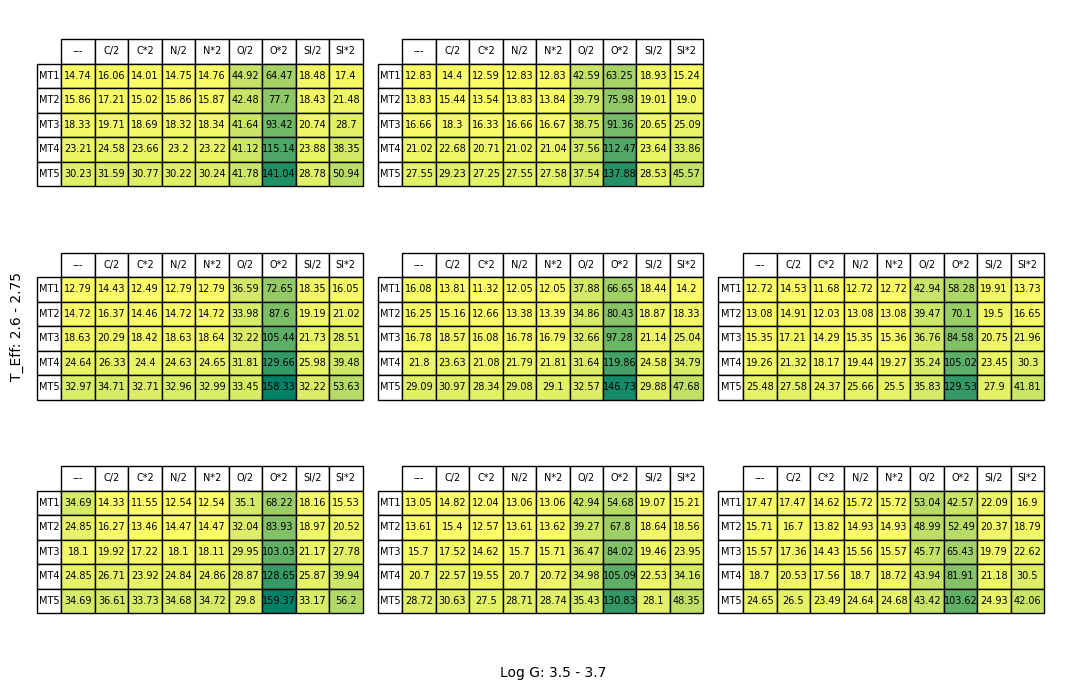

In [18]:
plot_chi_table(obs_dataset, plot_chi_square, [mod_dataset_1, mod_dataset_2,mod_dataset_3,mod_dataset_4,mod_dataset_5,mod_dataset_6,mod_dataset_7,mod_dataset_8])

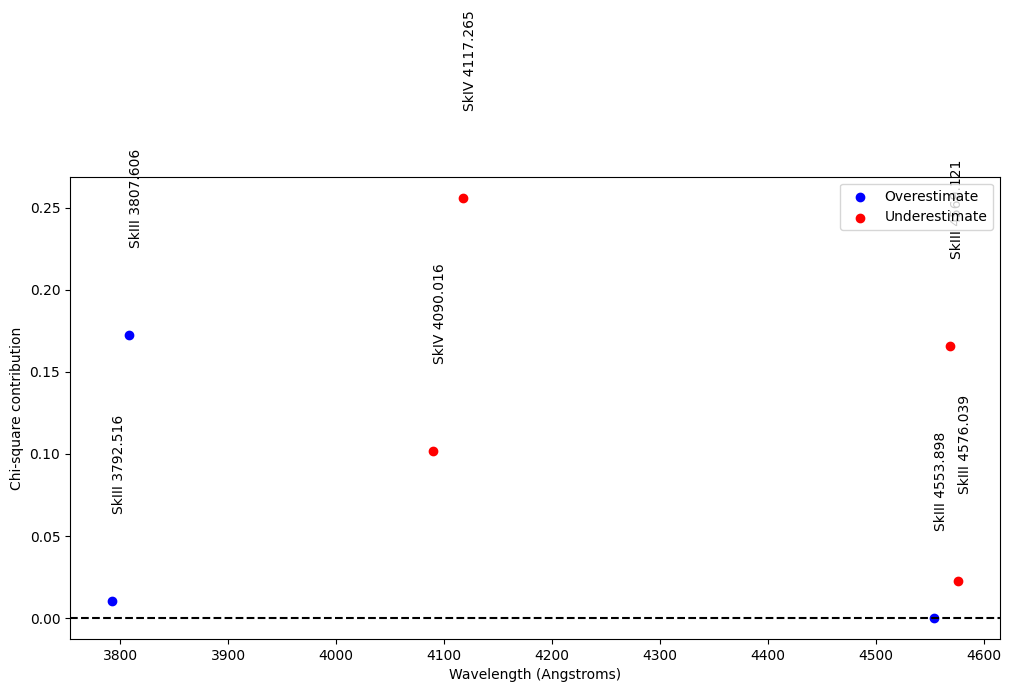

In [19]:
plot_chi_wavelength(obs_dataset,mod_dataset_6.get_micro_abund_storage(1,"C/2"),filter_list=["SkIII","SkIV"])

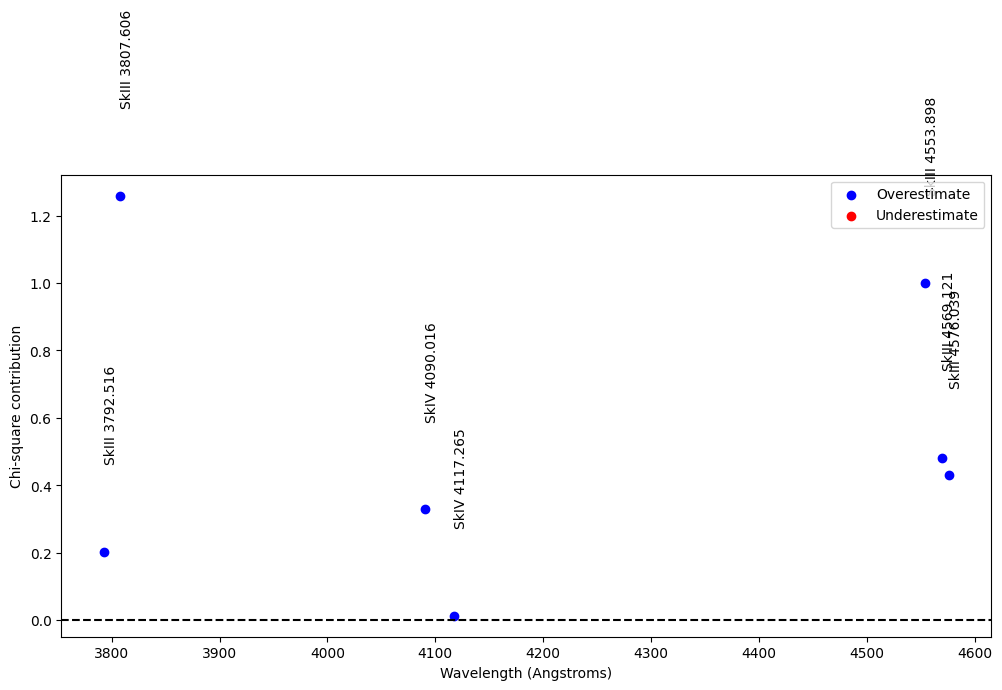

In [20]:
plot_chi_wavelength(obs_dataset,mod_dataset_6.get_micro_abund_storage(1,"SI*2"),filter_list=["SkIII","SkIV"])

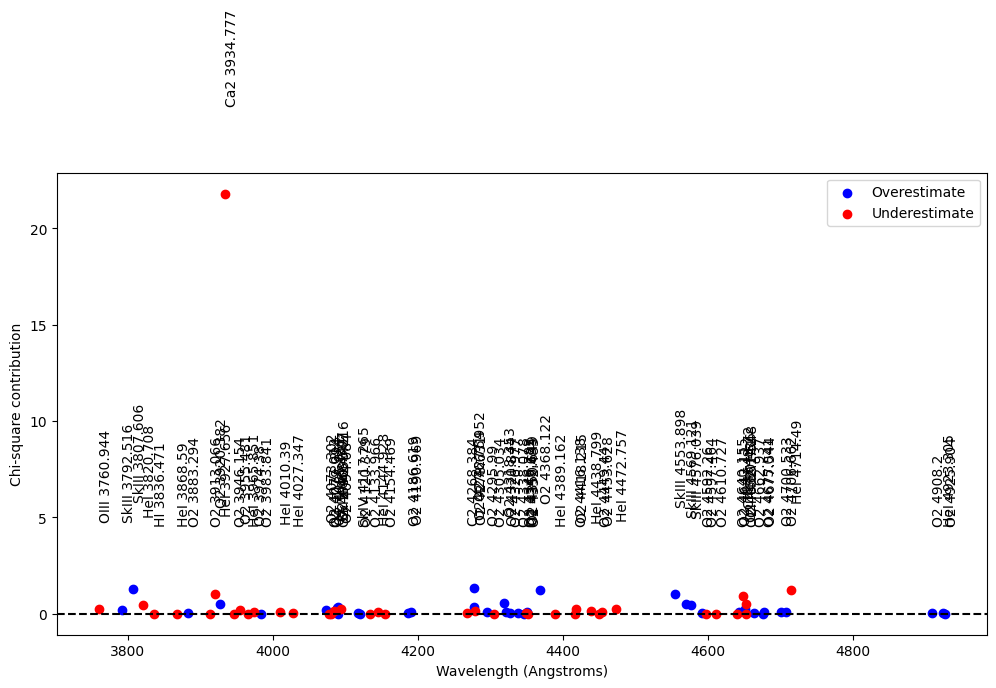

In [21]:
plot_chi_wavelength(obs_dataset,mod_dataset_6.get_micro_abund_storage(1,"SI*2"))

In [22]:
print(mod_dataset_6.get_micro_abund_storage(1,"")["SkIII"])
print(mod_dataset_6.get_micro_abund_storage(1,"C/2")["SkIII"])

{3792.516: 17.56, 3807.606: 60.89, 4553.898: 130.3, 4569.121: 102.69, 4576.039: 54.69}
{3792.516: 15.73, 3807.606: 50.06, 4553.898: 95.47, 4569.121: 78.54, 4576.039: 45.73}


# New XShooter Data

Read in all the FITS files and convert them to Hillier format(TM).

In [23]:
def read_fits_file(filename, name_list):
    hdul = fits.open(filename)
    for i in range(1,len(hdul)):
        data = hdul[i].data
        col_list = [0,2,3,16,17]
        f_str_list = ['%-f','%-E','%-E','%-f','%-f']
        data_table = np.column_stack(tuple(map(lambda v:data.field(v),col_list)))
        data_table = Table(data_table, names=(hdul[i].columns.names[k] for k in col_list))
        f = open(name_list[i-1],"w")
        f.write("FLUX_UNIT_2=ergs/cm^2/s/Ang\n")
        f.write("FLUX_UNIT_3=ergs/cm^2/s/Ang\n")
        f.write("FLUX_UNIT_4=Norm\n")
        f.write("FLUX_UNIT_5=Norm\n")
        f.write("WAVE_UNIT=Angstroms\n")
        f.write("AIR_LAM=False\n")
        astro_write.write(data_table, f, format='fixed_width_no_header',delimiter='',col_starts=[2,29,66,93,120],col_ends=[27,64,91,118,145],formats={hdul[i].columns.names[k]:f_str_list[j] for j,k in enumerate(col_list)})
        f.close()
        

In [24]:
read_fits_file("XSH-U_AV304_INDIV1D.fits",['XSH_UV1','XSH_UV2','XSH_VIS1','XSH_VIS2'])

In [25]:
hdul = fits.open("AV304_CLA_MI_18dec2022_norm.fits")
hdul.info()


Filename: AV304_CLA_MI_18dec2022_norm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     107   (174380,)   float32   


In [26]:
hdul = fits.open("AV304_CLA_MI_18dec2022_merged.fits")
#hdul.info()
data = hdul[0].data
header = hdul[0].header
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =               174379 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2023-06-30T15:37:03' / Date FITS file was generated                  
IRAF-TLM= '2023-06-30T15:37:03' / Time of last modification                     
OBJECT  = 'AV304   '           / Name of the object observed                    
BUNIT   = 'erg/cm2/s/A'                                                         
SITENAME= 'LCO'                                                                 
SITEALT =                 2405         / meters                                 
SITELAT =            -29.014

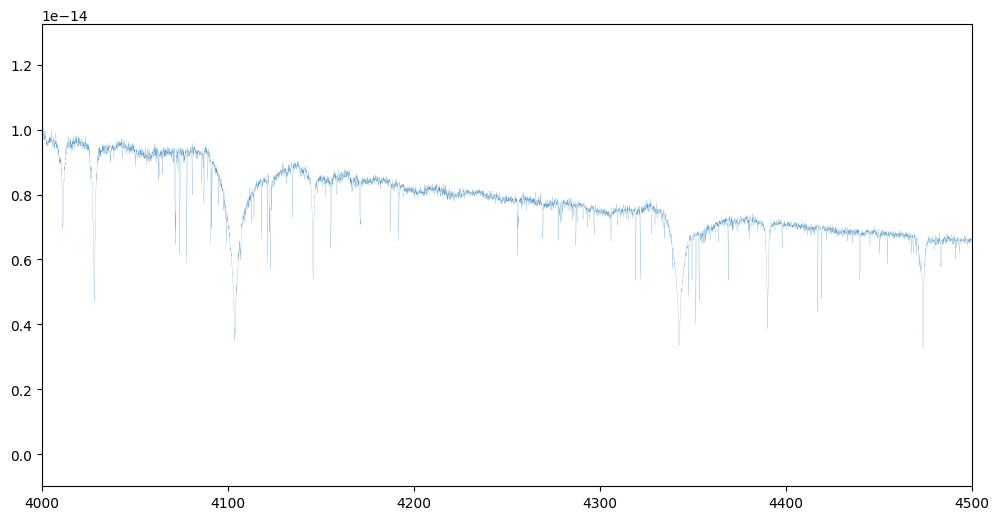

In [27]:
plt.figure(figsize=(12,6))
plt.plot([(x*header['CDELT1'])+header['CRVAL1'] for x in range(len(data))],data,linewidth=0.1)
plt.xlim([4000,4500])
plt.show()
hdul.close()
#read_fits_file("AV304_CLA_MI_18dec2022_merged.fits")

In [28]:
def read_fits_file_pain(filename, name_list):
    hdul = fits.open(filename)
    data = hdul[0].data
    header = hdul[0].header
    wv_list = [(x*header['CDELT1'])+header['CRVAL1'] for x in range(len(data))]
    f_str_list = ['%-f','%-E']
    data_table = np.column_stack((np.array(wv_list).T,np.array(data).T))
    data_table = Table(data_table, names=('WAVELENGTH','FLUX'))
    f = open(name_list[0],"w")
    f.write("FLUX_UNIT=ergs/cm^2/s/Ang\n")
    f.write("WAVE_UNIT=Angstroms\n")
    f.write("AIR_LAM=False\n")
    astro_write.write(data_table, f, format='fixed_width_no_header',delimiter='',col_starts=[2,29],col_ends=[27,64],formats={'WAVELENGTH':'%-f','FLUX':'%-E'})
    f.close()

In [29]:
read_fits_file_pain("AV304_CLA_MI_18dec2022_merged.fits",['AV304_HI_RES_MERGED'])

In [30]:
hdul = fits.open("AV304_CLA_MI_18dec2022_norm.fits")
data = hdul[0].data
header = hdul[0].header
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =               174380 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2023-06-30T18:24:53' / Date FITS file was generated                  
IRAF-TLM= '2023-06-30T18:24:53' / Time of last modification                     
OBJECT  = 'AV304   '           / Name of the object observed                    
BUNIT   = 'erg/cm2/s/A'                                                         
SITENAME= 'LCO'                                                                 
SITEALT =                 2405         / meters                                 
SITELAT =            -29.014

In [31]:
read_fits_file_pain("AV304_CLA_MI_18dec2022_norm.fits",['AV304_HI_RES_NORM'])

In [33]:
hi_res_obs_dataset = ObsDataset("EW_DATA_HI_RES_NORM")

{'OIII': 1, 'O2': 53, 'SkIII': 5, 'HeI': 12, 'HI': 1, 'Ca2': 1, 'SkIV': 2, 'C2': 1, 'CIII': 2}
{'HeI': 15, 'O2': 37, 'SkIV': 1, 'C2': 3, 'SkIII': 3, 'CIII': 1, 'HI': 3}


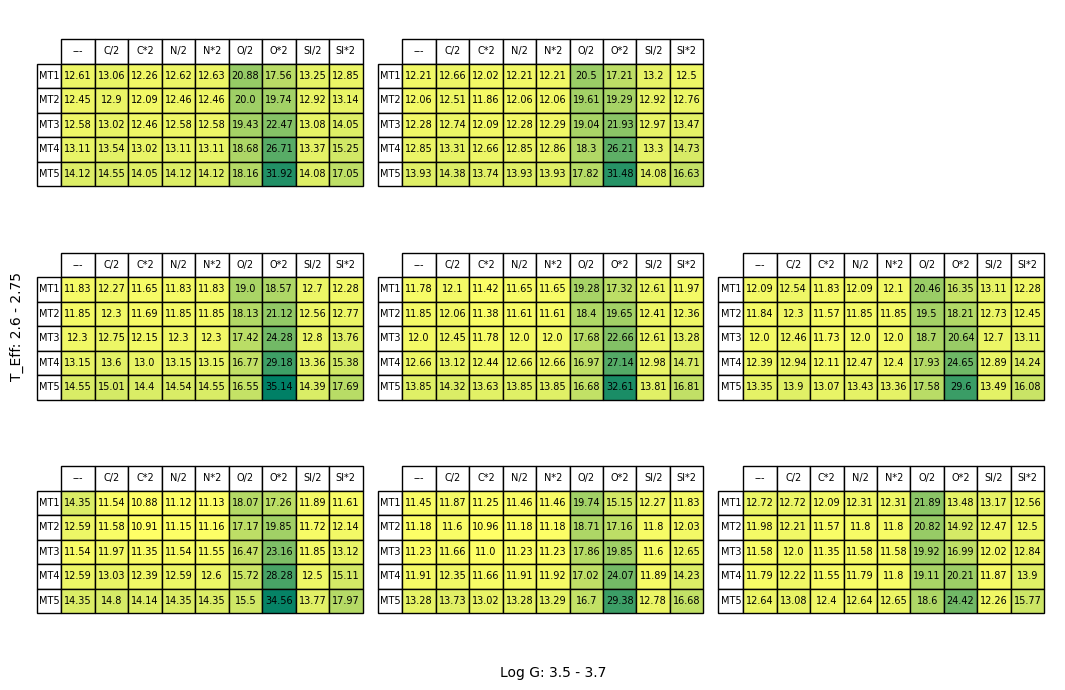

In [34]:
plot_chi_table(hi_res_obs_dataset, plot_chi_square, [mod_dataset_1, mod_dataset_2,mod_dataset_3,mod_dataset_4,mod_dataset_5,mod_dataset_6,mod_dataset_7,mod_dataset_8])

![](h_lines.png)